### Import the necessary libraries

In [7]:
import pickle 
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import os
import warnings
import itertools

from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV, train_test_split
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

np.random.seed(10)

import multiprocessing

# check number of processors on current machine
print("Number of CPUs on current machine: %d" % multiprocessing.cpu_count())

# select the processor to be used (comment if processors >= 4)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

Number of CPUs on current machine: 4


### Get preprocessed data (241 samples)

In [3]:
X = pickle.load(open( "../../data/preprocessed/article-genetic-data-features.p", "rb"))
y = pickle.load(open( "../../data/preprocessed/article-genetic-data-labels.p", "rb"))

print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [4]:
X.shape

(241, 1309)

In [5]:
len(y)

241

In [27]:
# intermediate/test split (gives us test set)
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

# train/validation split (gives us train and validation sets)
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate, y_intermediate, 
                                                                test_size=0.22, random_state=1)

In [28]:
# delete intermediate variables
del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y),2),
                                                       round(len(y_validation)/len(y),2),
                                                       round(len(y_test)/len(y),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [81]:
len(y_train), len(y_validation), len(y_test)

(168, 48, 25)

48

### Create function to plot Confusion Matrix without Normalization

In [42]:
def plot_confusion_matrix(cm, model_name):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Drug Response Prediction Confusion Matrix without Normalization')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    classNames = ['Refractory','Responsive']
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    # set the layout approach without normalization
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]))
    # save plot as image 
    plt.savefig('../figures/default-confusion-matrixes/%s-gridsearch-genetic-default-cm' % model_name.lower())
    plt.show()    

### Create function to plot a Normalized Confusion Matrix

In [43]:
def plot_normalized_confusion_matrix(cm, model_name, use_portuguese=True):
    # apply normalization
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot matrix
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # check language to be used
    if(use_portuguese):
        plt.title('Dados genéticos - Matriz de Confusão Normalizada')
        plt.colorbar()
        plt.ylabel('Rótulo verdadeiro') 
        plt.xlabel('Rótulo previsto') 
        classNames = ['Refratário','Responsivo'] 
    else:
        plt.title('Normalized Drug Response Prediction Confusion Matrix')
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        classNames = ['Refractory','Responsive']
    
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    # set the normalized layout approach
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    # save plot as image 
    plt.savefig('../figures/normalized-confusion-matrixes/%s-gridsearch-genetic-normalized-cm.pdf' % model_name.lower(), dpi=300, 
                pad_inches=0, bbox_inches='tight')
    plt.show()

### Create function to plot ROC curve

In [44]:
def plot_roc_curve(fpr, tpr, auc_score, model_name, use_portuguese=True):
    plt.figure(1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    plt.plot(fpr, tpr, color='darkorange', label='AUC = %f)' % auc_score)
    
    # check language to be used
    if(use_portuguese):    
        plt.xlabel('Taxa de falsos positivos')
        plt.ylabel('Taxa de verdadeiros positivos') 
        plt.title('Dados genéticos - Curva ROC') 
    else:
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('Drug Response Prediction - ROC Curve')
    
    plt.legend(loc='best')
    # save plot as image 
    plt.savefig('../figures/roc-curves/%s-gridsearch-genetic-roc-curve.pdf' % model_name.lower(), dpi=300)
    plt.show()

### Create function to be used to perform model fitting using LOOCV 

In [45]:
def fit_model(model, X, y):
    
    # prepare a LOOCV object (number of folds equals the number of samples)
    loocv = LeaveOneOut()
    loocv.get_n_splits(X)
    
    # perform cross-validation and get the accuracies
    cv_score = cross_val_score(model, X, y, cv=loocv, scoring='accuracy')
    
    # perform cross-validation and get the predictions and predictions probabilities
    preds = cross_val_predict(model, X, y, cv=loocv)
    predprobs = cross_val_predict(model, X, y, cv=loocv, method='predict_proba')[:,1]
    
    # calculate fpr and tpr values using the y_true and predictions probabilities
    fpr, tpr, _ = metrics.roc_curve(y, predprobs)
    
    # calculate the auc score based on fpr and tpr values
    auc_score = metrics.auc(fpr, tpr)

    # generate the confusion matrix for the model results and slice it into four pieces
    cm = metrics.confusion_matrix(y, preds)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    # print model informqtion
    print("\nModel Report\n")
    print(model) # print the used params for the model

    # print classification report
    print("\nAccuracy (CV Score) : Mean - %.7g | Std - %.7g" % (np.mean(cv_score), np.std(cv_score)))
    print("\nAUC Score : %f" % auc_score)
    
    # calculate sensitivity score
    # specificity: When the actual value is negative, how often is the prediction correct?
    # how "specific" (or "selective") is the classifier in predicting positive instances?
    specificity = TN / float(TN + FP)
    print("\nSpecificity Score : %f" % specificity)
    
    # calculate sensitivity score
    # sensitivity: When the actual value is positive, how often is the prediction correct?
    # how "sensitive" is the classifier to detecting positive instances? Also known as "True Positive Rate" or "Recall"
    sensitivity = TP / float(TP + FN)
    print("\nSensitivity Score : %f" % sensitivity)
    
    # print a complete classification metrics report
    print("\n" + metrics.classification_report(y, preds)) 
    
    # get current model name
    model_name = str(model).split('(')[0]
    
    # plot confusion matrix
    plot_confusion_matrix(cm, model_name)
    
    # plot normalized confusion matrix
    plot_normalized_confusion_matrix(cm, model_name) 

    # plot the roc curve
    plot_roc_curve(fpr, tpr, auc_score, model_name)
    
    return predprobs, fpr, tpr, auc_score 

In [82]:
def gridsearch_fit(model, param_grid):
    
    # DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and 
    # will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', iid=True)
    
    # fit the grid with data
    grid.fit(X_train, y_train)

    # show single best score achieved across all params
    print("\nAccuracy (GridSearchCV Score) : %f" % (grid.best_score_))

    # show dictionary containing the parameters used to generate that score
    print("\nBest parameters : %s \n" % grid.best_params_)

    # get actual model object fit with those best parameters 
    estimator = grid.best_estimator_
    
    # print all model params
    print(estimator) 
    
    # get the predictions and predictions probabilities
    preds = estimator.predict(X_validation)
    predprobs = estimator.predict_proba(X_validation)[:, 1]
    
    # calculate fpr and tpr values using the y_true and predictions probabilities
    fpr, tpr, _ = metrics.roc_curve(y_validation, predprobs)
    
    # calculate the auc score based on fpr and tpr values
    auc_score = metrics.auc(fpr, tpr)

    print("\nAUC Score : %f" % auc_score)
    
    # generate the confusion matrix for the model results and slice it into four pieces
    cm = metrics.confusion_matrix(y_validation, preds)
    TP, TN, FP, FN = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    
    # calculate sensitivity score
    # specificity: When the actual value is negative, how often is the prediction correct?
    # how "specific" (or "selective") is the classifier in predicting positive instances?
    specificity = TN / float(TN + FP)
    print("\nSpecificity Score : %f" % specificity)
    
    # calculate sensitivity score
    # sensitivity: When the actual value is positive, how often is the prediction correct?
    # how "sensitive" is the classifier to detecting positive instances? Also known as "True Positive Rate" or "Recall"
    sensitivity = TP / float(TP + FN)
    print("\nSensitivity Score : %f" % sensitivity)
    
    # print a complete classification metrics report
    print("\n" + metrics.classification_report(y_validation, preds)) 
    
    # get current model name
    model_name = str(estimator).split('(')[0]
    
    # plot confusion matrix
    plot_confusion_matrix(cm, model_name)
    
    # plot normalized confusion matrix
    plot_normalized_confusion_matrix(cm, model_name) 

    # plot the roc curve
    plot_roc_curve(fpr, tpr, auc_score, model_name)
    
    return predprobs, fpr, tpr, auc_score 

### Create a DecisionTreeClassifier model with parameter tunning


Accuracy (GridSearchCV Score) : 0.779762

Best parameters : {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 16} 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

AUC Score : 0.884766

Specificity Score : 0.781250

Sensitivity Score : 1.000000

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        32
           1       0.70      1.00      0.82        16

   micro avg       0.85      0.85      0.85        48
   macro avg       0.85      0.89      0.85        48
weighted avg       0.90      0.85      0.86        48



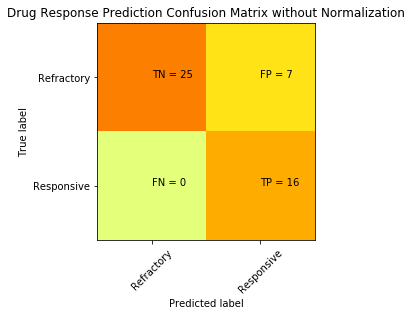

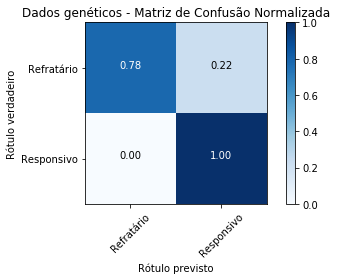

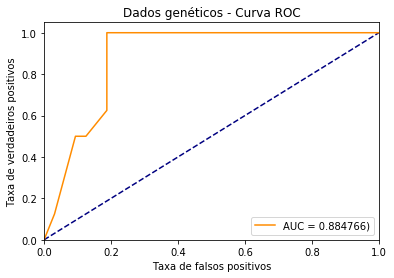

In [85]:
dt = DecisionTreeClassifier(random_state=10)

param_grid_dt = {'max_depth': np.arange(1, 21), 
                 'min_samples_split': np.arange(2, 51), 
                 'min_samples_leaf': np.arange(1, 16)}

# perform model fitting
dt_predprobs, fpr_dt, tpr_dt, auc_dt = gridsearch_fit(dt, param_grid_dt)

# export prediction probabilities 
pickle.dump(dt_predprobs, open("../predictions/dt-genetic-predprobs.p", "wb"))

In [87]:
g = GridSearchCV(dt, {})

g

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Create a RandomForestClassifier model with parameter tunning

In [ ]:
rf = RandomForestClassifier(random_state=10)

param_grid_rf = {}

# perform model fitting
rf_predprobs, fpr_rf, tpr_rf, auc_rf = gridsearch_fit(rf, param_grid_rf)

# export prediction probabilities 
pickle.dump(rf_predprobs, open("../predictions/rf-gridsearch-genetic-predprobs.p", "wb"))

### Create a SVM baseline model using a reduced set of tuned parameters


Model Report

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=10, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [0.01, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.01, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Accuracy (CV Score) : Mean - 0.7966805 | Std - 0.4024682

AUC Score : 0.834271

Specificity Score : 0.870370

Sensitivity Score : 0.645570

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       162
          1       0.71      0.65      0.68        79

avg / total       0.79      0.80      0.79       241



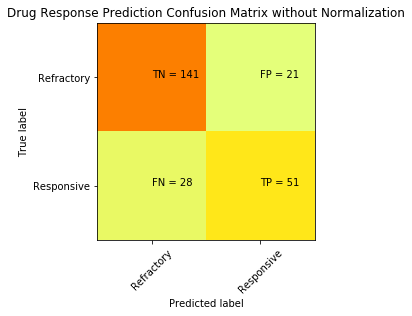

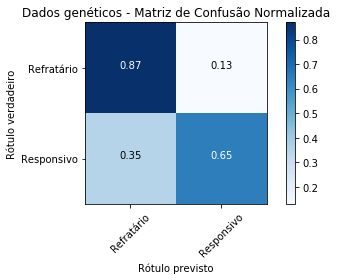

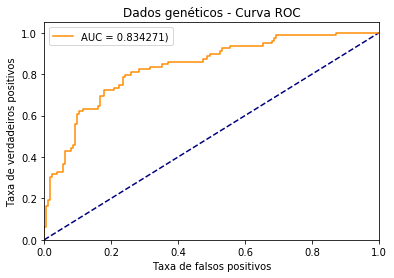

In [9]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.01, 1, 10, 100]}, 
                    {'kernel': ['linear'], 'C': [0.01, 1, 10, 100]}]

clf = GridSearchCV(SVC(probability=True, random_state=10), tuned_parameters) # svc = SVC(probability=True, random_state=10)

# perform model fitting
svc_predprobs, fpr_svc, tpr_svc, auc_svc = fit_model(clf, X, y)

# export prediction probabilities 
pickle.dump(svc_predprobs, open("./predictions/svc-genetic-predprobs.p", "wb"))

### Create a GBM baseline model with parameter tunning


Model Report

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=1.0, verbose=0, warm_start=False)

Accuracy (CV Score) : Mean - 0.7925311 | Std - 0.4054942

AUC Score : 0.865213

Specificity Score : 0.907407

Sensitivity Score : 0.556962

             precision    recall  f1-score   support

          0       0.81      0.91      0.85       162
          1       0.75      0.56      0.64        79

avg / total       0.79      0.79      0.78       241



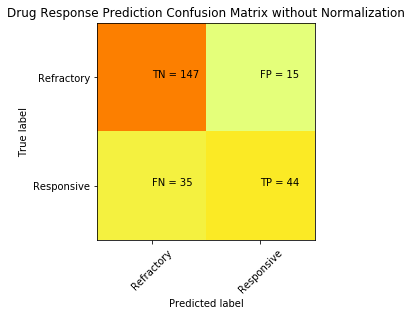

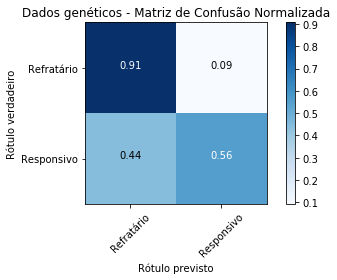

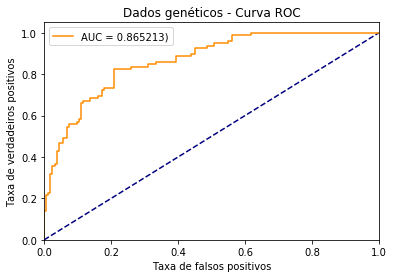

In [10]:
gbm = GradientBoostingClassifier(random_state=10)

# perform model fitting
gbm_predprobs, fpr_gbm, tpr_gbm, auc_gbm = fit_model(gbm, X, y)

# export prediction probabilities 
pickle.dump(gbm_predprobs, open("../predictions/gbm-genetic-predprobs.p", "wb"))

### Create a XGB baseline model using default parameters


Model Report

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy (CV Score) : Mean - 0.813278 | Std - 0.3896882

AUC Score : 0.882482

Specificity Score : 0.882716

Sensitivity Score : 0.670886

             precision    recall  f1-score   support

          0       0.85      0.88      0.86       162
          1       0.74      0.67      0.70        79

avg / total       0.81      0.81      0.81       241



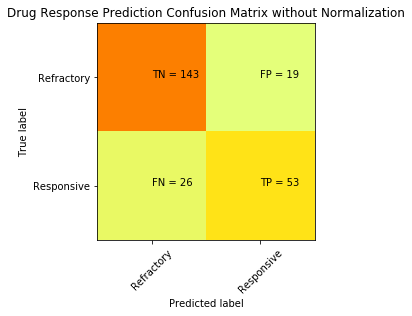

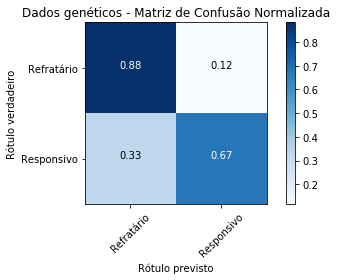

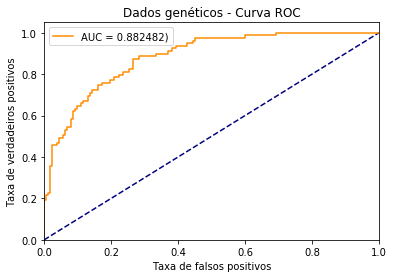

In [11]:
xgb = XGBClassifier()

# ignore deprecation warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# perform model fitting
xgb_predprobs, fpr_xgb, tpr_xgb, auc_xgb = fit_model(xgb, X, y)

# export prediction probabilities 
pickle.dump(xgb_predprobs, open("./predictions/xgb-genetic-predprobs.p", "wb"))

### Compare all generated ROC curves

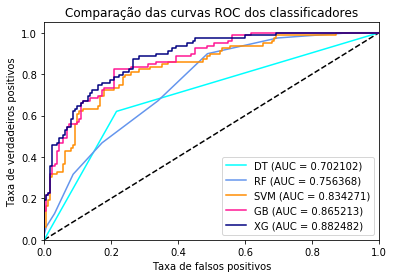

In [12]:
# get prediction probabilities from individual classifiers
dt_predprobs = pickle.load( open( "./predictions/dt-genetic-predprobs.p", "rb" ) )
rf_predprobs = pickle.load( open( "./predictions/rf-genetic-predprobs.p", "rb" ) )
svc_predprobs = pickle.load( open( "./predictions/svc-genetic-predprobs.p", "rb" ) )
gbm_predprobs = pickle.load( open( "./predictions/gbm-genetic-predprobs.p", "rb" ) )
xgb_predprobs = pickle.load( open( "./predictions/xgb-genetic-predprobs.p", "rb" ) )

# calculate fpr, tpr and auc score for all models using the y_true and its predictions probabilities
fpr_dt, tpr_dt, _ = metrics.roc_curve(y, dt_predprobs)
auc_dt = metrics.auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = metrics.roc_curve(y, rf_predprobs)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

fpr_svc, tpr_svc, _ = metrics.roc_curve(y, svc_predprobs)
auc_svc = metrics.auc(fpr_svc, tpr_svc)

fpr_gbm, tpr_gbm, _ = metrics.roc_curve(y, gbm_predprobs)
auc_gbm = metrics.auc(fpr_gbm, tpr_gbm)

fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y, xgb_predprobs)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

# plot all roc curves into the same image
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  , 
plt.plot(fpr_dt, tpr_dt, color='aqua', label='DT (AUC = %f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, color='cornflowerblue', label='RF (AUC = %f)' % auc_rf)
plt.plot(fpr_svc, tpr_svc, color='darkorange', label='SVM (AUC = %f)' % auc_svc)
plt.plot(fpr_gbm, tpr_gbm, color='deeppink', label='GB (AUC = %f)' % auc_gbm)
plt.plot(fpr_xgb, tpr_xgb, color='navy', label='XG (AUC = %f)' % auc_xgb)
plt.xlabel('Taxa de falsos positivos') # False positive rate
plt.ylabel('Taxa de verdadeiros positivos') # True positive rate
plt.title('Comparação das curvas ROC dos classificadores') # Drug Response Prediction - ROC Curve
plt.legend(loc='lower right')
# save plot as image 
plt.savefig('./figures/roc-curves/genetic-models-comparison-roc-curves.pdf', dpi=300)
plt.show()